In [4]:
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import tensorflow
import gc

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))
    
reset_keras()    

145


In [5]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import class_weight

import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import CuDNNLSTM
from tensorflow.keras.regularizers import L1L2

In [6]:
train_df = pd.read_csv("./input/train.csv")

print("Train shape : ",train_df.shape)


Train shape :  (1306122, 3)


In [7]:
## Config values 
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=2019)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=2020)
print("Validation shape : ",val_df.shape)
print("Test shape : ",test_df.shape)
embed_size = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 50 # max number of words in a question to use

## fill up the missing values
train_X = train_df["question_text"].fillna("_na_").values
val_X = val_df["question_text"].fillna("_na_").values
test_X = test_df["question_text"].fillna("_na_").values

## Tokenize the sentences
oov_tok = "OOV_TOK"
tokenizer = Tokenizer(num_words=max_features) # lower = False, oov_token=oov_tok)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen, truncating='post')
val_X = pad_sequences(val_X, maxlen=maxlen, truncating='post')
test_X = pad_sequences(test_X, maxlen=maxlen, truncating='post')

## Get the target values
train_y = train_df['target'].values
val_y = val_df['target'].values
test_y = test_df['target'].values

Validation shape :  (130612, 3)
Test shape :  (130613, 3)


In [8]:
EMBEDDING_FILE = './input/embeddings/glove.840B.300d/glove.840B.300d.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        

/home/user1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """


In [13]:
regularizer = L1L2(l1=0.0, l2=0.001)
del model
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, trainable=True, weights=[embedding_matrix])(inp)
x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 300)           15000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 128)           187392    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total para

In [14]:
# Define callback function if detailed log required

class History(Callback):
    def on_train_begin(self, logs={}):
        self.train_loss = []
        self.train_acc = []
        self.val_acc = []
        self.val_loss = []
        for keys in logs:
           print(keys) 

    def on_batch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.train_acc.append(logs.get('acc'))
    #Store val_acc/loss per batch    
    def on_epoch_end(self, batch, logs={}):    
        self.val_acc.append(logs.get('val_acc'))
        self.val_loss.append(logs.get('val_loss'))
        
# Compute class_weights for imbalanced train set
def compute_class_weight(input_list):

  class_weights = class_weight.compute_class_weight('balanced', 
                                                   np.unique(input_list),  
                                                   input_list)
                                                   
  return(class_weights)                                                   
        
#define callback functions
history = History()
callbacks = [history]        

class_weights = compute_class_weight(train_y)

class_weights[1] *= 10
print(class_weights)

[ 0.53290517 80.97591407]


In [15]:

model.fit(train_X, train_y, 
          batch_size=512, 
          epochs=1, 
          validation_data=(val_X, val_y), 
          class_weight = class_weights,
          callbacks= callbacks)
model.save('./output/model_glove_emb.h5')

Train on 1044897 samples, validate on 130612 samples
1044897/1044897 [==============================] - 49s 47us/sample - loss: 0.1116 - acc: 0.9565 - val_loss: 0.1035 - val_acc: 0.9591


In [16]:
#from tensorflow.keras.models import Model, load_model

#model =load_model('./output/model_glove.h5')
pred_glove_val_y = model.predict([val_X], batch_size=1024, verbose=1)
threshold = []
f1_array = []
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    threshold.append(thresh)
    f1_score = metrics.f1_score(val_y, (pred_glove_val_y>thresh).astype(int))
    f1_array.append(f1_score)
    print("F1 score at threshold {0} is {1}".format(thresh, f1_score))

130612/130612 [==============================] - 1s 11us/sample
F1 score at threshold 0.1 is 0.6096680461389452
F1 score at threshold 0.11 is 0.6180458579215279
F1 score at threshold 0.12 is 0.6252359250563919
F1 score at threshold 0.13 is 0.6310994223453718
F1 score at threshold 0.14 is 0.6357812201185695
F1 score at threshold 0.15 is 0.6400699742455901
F1 score at threshold 0.16 is 0.6436747582395894
F1 score at threshold 0.17 is 0.6479507581444228
F1 score at threshold 0.18 is 0.6522445663213489
F1 score at threshold 0.19 is 0.6554370782465359
F1 score at threshold 0.2 is 0.6571339108652542
F1 score at threshold 0.21 is 0.6590070622957732
F1 score at threshold 0.22 is 0.6599190283400809
F1 score at threshold 0.23 is 0.6610005379236149
F1 score at threshold 0.24 is 0.661771904062653
F1 score at threshold 0.25 is 0.6622734761120264
F1 score at threshold 0.26 is 0.6626425960793001
F1 score at threshold 0.27 is 0.6641711827476395
F1 score at threshold 0.28 is 0.6640743871513103
F1 score

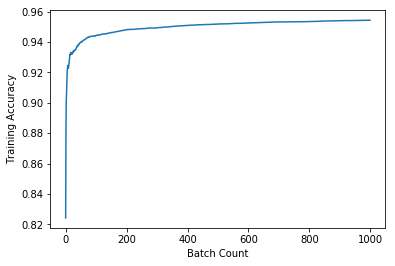

In [17]:
x = range(len(history.train_acc))
%matplotlib inline
fig = plt.figure()
plt.xlabel('Batch Count')
plt.ylabel('Training Accuracy')
plt.plot(x[0:1000], history.train_acc[0:1000])
plt.show()
#fig.savefig('glove_emb_accuracy')

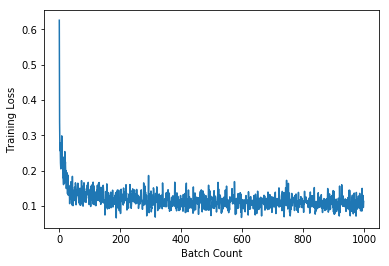

In [18]:
fig = plt.figure()
plt.xlabel('Batch Count')
plt.ylabel('Training Loss')
plt.plot(x[0:1000], history.train_loss[0:1000])
plt.show()
#fig.savefig('glove_emb_loss')

In [ ]:

%matplotlib inline
fig = plt.figure()
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.plot(threshold, f1_array)
plt.show()
#fig.savefig('self_train_emb_F1_score')

In [27]:
pred_test_y = model.predict([test_X], batch_size=1024, verbose=1)
threshold = []
f1_array = []
f1_max = 0
opt_thresh = 0
test_y = test_df['target'].values
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    threshold.append(thresh)
    f1_score = metrics.f1_score(test_y, (pred_test_y>thresh).astype(int))
    if(f1_score > f1_max):
        f1_max = f1_score
        opt_thresh = thresh
    f1_array.append(f1_score)
    print("F1 score at threshold {0} is {1}".format(thresh, f1_score))

pred = [int(a > opt_thresh) for a in pred_test_y]    

130613/130613 [==============================] - 1s 10us/sample
F1 score at threshold 0.1 is 0.6193475028426485
F1 score at threshold 0.11 is 0.6273439248153949
F1 score at threshold 0.12 is 0.6334626797534809
F1 score at threshold 0.13 is 0.6388682055100521
F1 score at threshold 0.14 is 0.6438557414340552
F1 score at threshold 0.15 is 0.6481749012809399
F1 score at threshold 0.16 is 0.6525183374083129
F1 score at threshold 0.17 is 0.6556547619047619
F1 score at threshold 0.18 is 0.6594610898853812
F1 score at threshold 0.19 is 0.6612377850162866
F1 score at threshold 0.2 is 0.6634729305104826
F1 score at threshold 0.21 is 0.6665276329509906
F1 score at threshold 0.22 is 0.6684254959898691
F1 score at threshold 0.23 is 0.6698956780923994
F1 score at threshold 0.24 is 0.6722210277359709
F1 score at threshold 0.25 is 0.6727845351867942
F1 score at threshold 0.26 is 0.6741597675311147
F1 score at threshold 0.27 is 0.6758177893396801
F1 score at threshold 0.28 is 0.6770071974557831
F1 scor

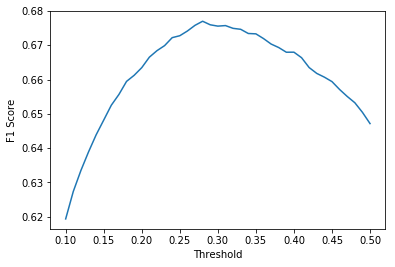

In [20]:
fig = plt.figure()
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.plot(threshold, f1_array)
plt.show()
#fig.savefig('glove_emb_F1_score')

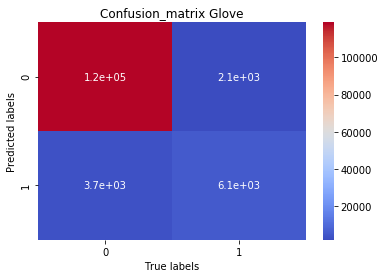

In [54]:
from sklearn.metrics import classification_report, confusion_matrix
import scikitplot as skplt
import seaborn as sns
def get_confusion_matrix(val_y, pred,title):
    cm=confusion_matrix(pred,val_y)
   
    fig = plt.figure()
    sns.heatmap(cm, cmap='coolwarm', annot=True)
    plt.title(title)
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()
    #fig.savefig('glove_confusion_matrix')
 
get_confusion_matrix(test_y,pred,'Confusion_matrix Glove')    

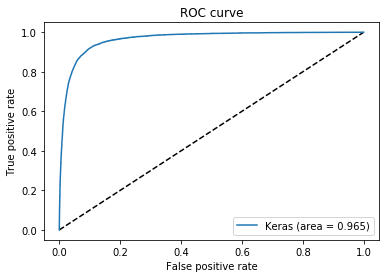

In [55]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_y, pred_test_y)
auc_keras = auc(fpr_keras, tpr_keras)
fig = plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#fig.savefig('glove_ROC')